<h2 style="color:green">Importing Necessary Libraries</h2>

In [1]:
import requests
from bs4 import BeautifulSoup
import re
from nltk.tokenize import sent_tokenize
import plotly.express as px
from collections import Counter
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

2024-04-08 04:58:34.029527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 04:58:34.029616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 04:58:34.207844: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h2 style="color:Orange">Data Scraping and Cleaning</h2>


In [2]:
# Function to fetch and preprocess the script content from a given URL
def fetch_and_preprocess_scripts(url):
    base_url = "https://transcripts.foreverdreaming.org"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    anchor_tags = soup.find_all("a", class_="topictitle")
    links = [base_url + tag["href"][1:] for tag in anchor_tags]
    links = links[2:]
    links.reverse()

    final_script = ""
    
    for link in links:
        response = requests.get(link)
        soup = BeautifulSoup(response.content, "html.parser")
        script_div = soup.find("div", class_="content")
        script_text = script_div.get_text(separator="\n") if script_div else ""

        final_script += script_text.strip() + "\n"

    preprocessed_script = preprocess_text(final_script)
    return preprocessed_script

# Function to clean and preprocess the text
def preprocess_text(text):
    cleaned_text = re.sub(r'<[^>]+>', '', text)
    cleaned_text = re.sub(r'\[[^\]]+\]', '', cleaned_text)
    sentences = sent_tokenize(cleaned_text)
    
    preprocessed_text = ' '.join(sentence.lower() for sentence in sentences)
    
    return preprocessed_text


url = "https://transcripts.foreverdreaming.org/viewforum.php?f=429&sid=acbdaf84cb954f2929838f627cb124cb&start=78"
newpreprocessed_script = fetch_and_preprocess_scripts(url)
url1 = "https://transcripts.foreverdreaming.org/viewforum.php?f=429"
new_preprocessed_script = fetch_and_preprocess_scripts(url1)
preprocessed_script = newpreprocessed_script+new_preprocessed_script

In [3]:
print(preprocessed_script[:500])

***cold open***



(episode opens on a sh*t of police officer jake peralta staring seriously into the camera.) jake: this job is eating me alive. (voice-over continues over dramatic sh*ts of jake exiting a police car, crossing a street, ducking under “crime scene — do not cross” tape to enter a doorway, all in slow-motion.) jake (voice-over): i can't breathe anymore. i spent all these years trying to be the good guy, the man in the white hat. (back to jake, speaking in real time—)



jake: i’m n


<h2 style="color:violet">Exploratory Data Analysis</h2>

In [4]:
tokens = preprocessed_script.split()

token_counter = Counter(tokens)

most_common_tokens = token_counter.most_common(20)
token_labels, token_counts = zip(*most_common_tokens)

data = {'Word': token_labels, 'Frequency': token_counts}
df = pd.DataFrame(data)

fig = px.bar(df, x='Word', y='Frequency', title='Most Common Words')
fig.update_xaxes(tickangle=45)
fig.show()

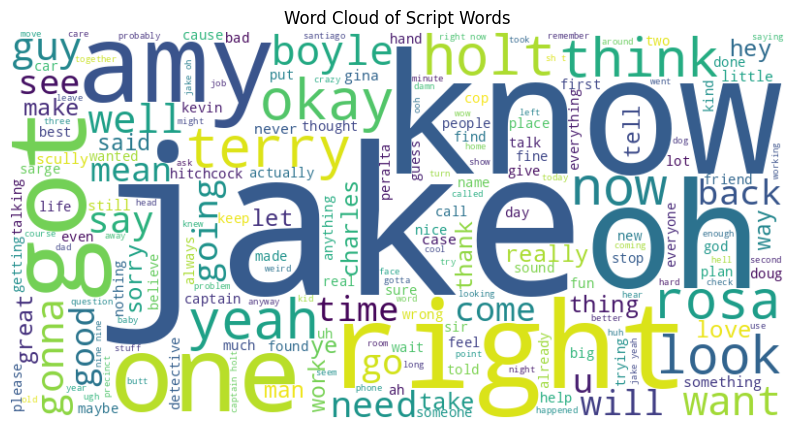

In [34]:
text = ' '.join(tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Script Words')
plt.show()

<h2 style="color:Blue">Data Preparation</h2>

In [3]:
# Tokenizing the text into word
tokenizer = Tokenizer()
tokenizer.fit_on_texts([preprocessed_script])
total_words = len(tokenizer.word_index) + 1

# Creating sequences of tokens
input_sequences = []
for line in preprocessed_script.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Padding sequences to ensure uniform length
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Creating predictors and labels
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

# Converting labels to categorical format
from tensorflow.keras.utils import to_categorical
label = to_categorical(label, num_classes=total_words)

print("Total words:", total_words)
print("Max sequence length:", max_sequence_len)
print("Number of input sequences:", len(input_sequences))

2024-04-07 12:03:59.829955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 12:03:59.830062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 12:04:00.077198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Total words: 20932
Max sequence length: 1624
Number of input sequences: 595661


<h2 style="color:Red">Model Building</h2>

In [5]:
# Loading pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Tokenizing and encoding the script data
preprocessed_script_tokens = tokenizer(preprocessed_script, return_tensors="pt", max_length=1024, truncation=True)

# Defining file path to save tokenized data
file_path = "preprocessed_script.txt"
with open(file_path, "w") as f:
    f.write(preprocessed_script)

# Converting tokenized data into a PyTorch dataset
dataset = TextDataset(tokenizer=tokenizer, file_path=file_path, block_size=128)  # Adjust block_size as needed

# Defining data collator for language modeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Defining training arguments
training_args = TrainingArguments(
    output_dir="./script_generator",
    overwrite_output_dir=True,
    num_train_epochs=50,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
    report_to=[],  # Disable wandb logging
)

# Defining Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

# Training the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to ga

Step,Training Loss
500,3.411200
1000,3.248500
1500,3.112700
2000,3.038000
2500,2.970600
3000,2.889700
3500,2.860300
4000,2.753300
4500,2.742000
5000,2.657600


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

In [ ]:
# Loading the fine-tuned model
model = GPT2LMHeadModel.from_pretrained("/kaggle/working/fine_tuned_script_generator")

# Loading the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Generating text
prompt_text = "Detective Jake Peralta enters the precinct and announces:"  # Custom prompt text
input_ids = tokenizer.encode(prompt_text, return_tensors="pt")

# Generating text with a maximum length of 200 tokens
output = model.generate(input_ids, max_length=500, num_return_sequences=1, temperature=0.7)

# Decoding and printing the generated text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)



In [25]:
#Improving the format of the output
# Generating text with a maximum length of 500 tokens
output1 = model.generate(input_ids, max_length=500, num_return_sequences=1, temperature=0.7, do_sample=True)

# Decoding the generated text
generated_text = tokenizer.decode(output1[0], skip_special_tokens=True)

delimiters = [". ", "? ", "! ", "| "]
for delimiter in delimiters:
    generated_text = generated_text.replace(delimiter, delimiter + "\n")

# Printing each dialogue on a new line
print(generated_text.strip())

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detective Jake Peralta enters the precinct and announces:  "our night is coming to a close. 
death drop." jake: i see the color blue. 
this morning is terrible for everyone. 
rosa: i’m sorry. 
i just got off the phone with the da. 
this morning, i was so miserable, i cried. 
jake: you know what? 
don't worry about it. 
i just talked to my general manager. 
he agreed to reopen the first floor. 
we just have to stay here and go over our exit strategy. 
rosa: absolutely. 
jake: fine, good, then i'll talk to my general manager. 
he'll tell me any news about our exit strategy, and i won't ask about it. 
then i have two minutes to formulate a response. 
rosa: i'm gonna say something that will win us the room and scare off the da. 
jake: exactly. 
and this will almost certainly make things more difficult for me than ever. 
rosa: i know. 
this was all you told me as soon as you left. 
jake: exactly. 
this is all you told me last night. 
i’m so sorry. 
all right. 
i understand you have no right

In [26]:
#Saving the model
model.save_pretrained("/kaggle/working/script_generatorr", save_format="tf")